<a href="https://colab.research.google.com/github/mehrnazeraeisi/KnnClassifier_Result/blob/main/Hill_Valley_with_Noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#   مشاهده نمودارها برای هر درصد دلخواه
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def evaluate_knn_on_dataset(X_data, y_data, test_size=0.2, n_repeats=20):
    # مرحله 1: محاسبه Accuracy برای تک‌ویژگی‌ها
    def compute_acc_per_feature(X, y):
        feature_scores = []
        for feature in X.columns:
            model = KNeighborsClassifier()
            model.fit(X[[feature]], y)
            y_pred = model.predict(X[[feature]])
            acc=accuracy_score(y, y_pred)
            feature_scores.append((feature, acc))
        df_scores = pd.DataFrame(feature_scores, columns=['Feature', 'Accuracy'])
        return df_scores.sort_values(by='Accuracy', ascending=False)

    # مرحله 2: بررسی گروه‌های افزایشی ویژگی‌ها
    def evaluate_incremental_feature_groups(X, y, sorted_features):
        results = []
        best_acc = -np.inf
        best_group = []
        for k in range(1, len(sorted_features) + 1):
            group = sorted_features[:k]
            model = KNeighborsClassifier()
            model.fit(X[group], y)
            y_pred = model.predict(X[group])
            acc=accuracy_score(y, y_pred)
            results.append((k, acc))
            if acc > best_acc:
                best_acc = acc
                best_group = group
        # اضافه کردن All Features به لیست
        model.fit(X, y)
        y_pred = model.predict(X)
        all_acc = accuracy_score(y, y_pred)
        results.append(("All Features", all_acc))
        return pd.DataFrame(results, columns=["Group Size", "Accuracy"]), best_group

    # اجرای مراحل
    single_feat_df = compute_acc_per_feature(X_data, y_data)
    sorted_features = single_feat_df['Feature'].tolist()
    group_results_df, best_group = evaluate_incremental_feature_groups(X_data, y_data, sorted_features)

    # مرحله 3: چاپ نتایج اولیه
    print("📌 نتایج Accuracy برای هر ویژگی:")
    print(single_feat_df.to_string(index=False))

    print("\n📊 نتایج عملکرد گروه‌های افزایشی Accuracy:")
    print(group_results_df.to_string(index=False))

    best_acc = group_results_df[group_results_df["Group Size"] == len(best_group)]["Accuracy"].values[0]

    print("\n🏆 بهترین گروه:")
    print(f"📌 تعداد ویژگی‌ها: {len(best_group)}")
    print(f"🔹 Accuracy: {best_acc:.4f}")

    # مرحله 4: ارزیابی نهایی با Split و رسم نمودار
    acc_scores = {"all_features": [], "best_group": []}

    feature_groups = {
        "all_features": X_data.columns.tolist(),
        "best_group": best_group
    }

    for _ in range(n_repeats):
        X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=test_size)
        for group_name, group_features in feature_groups.items():
            model = KNeighborsClassifier()
            model.fit(X_train[group_features], y_train)
            y_pred = model.predict(X_test[group_features])
            acc_scores[group_name].append(accuracy_score(y_test, y_pred))

    # رسم نمودار Accuracy
    x = np.arange(1, n_repeats + 1)
    plt.figure(figsize=(8, 4))
    for name, acc in acc_scores.items():
        plt.plot(x, acc, label=f"{name.replace('_', ' ').title()} Accuracy", marker='o')
    plt.xlabel("Repeat")
    plt.ylabel("Accuracy")
    plt.title("KNN Classifier Accuracy Performance")
    plt.legend()
    plt.grid(True)
    plt.show()


    # چاپ نتایج نهایی میانگین
    print("\n📈 میانگین نتایج پس از تکرار:")
    for name in feature_groups:
        avg_acc = np.mean(acc_scores[name])
        print(f"{name.replace('_', ' ').title()} → Accuracy: {avg_acc:.4f}")


In [ ]:
!pip install openml

(15545, 6)
Index(['id', 'start', 'end', 'event', 'size', 'rating'], dtype='object')
    id      start        end  event  size rating
0  1.0        0.0   913439.0      0  14.0      0
1  1.0   913439.0  1292405.0      1  14.0      0
2  1.0  1292405.0  1540749.0      0  14.0      1
3  2.0        0.0    50170.0      0  14.0      0
4  3.0        0.0   913439.0      0  18.0      0
(15545, 6)
📌 نتایج Accuracy برای هر ویژگی:
Feature  Accuracy
  start  0.956320
    end  0.835510
     id  0.780058
   size  0.677067
  event  0.328594

📊 نتایج عملکرد گروه‌های افزایشی Accuracy:
  Group Size  Accuracy
           1  0.956320
           2  0.943712
           3  0.943454
           4  0.944291
           5  0.944291
All Features  0.944291

🏆 بهترین گروه:
📌 تعداد ویژگی‌ها: 1
🔹 Accuracy: 0.9563


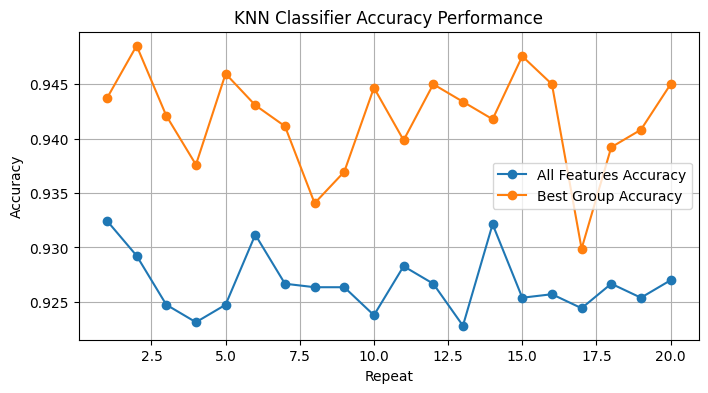


📈 میانگین نتایج پس از تکرار:
All Features → Accuracy: 0.9266
Best Group → Accuracy: 0.9418


In [ ]:

# Hill-Valley with Noise
# تشخیص سیگنال بالا یا پایین

import openml
import pandas as pd

dataset = openml.datasets.get_dataset(1046)
data, y_data, _, _ = dataset.get_data(target=dataset.default_target_attribute)

# 🔧 افزودن target به dataframe کامل (مثل خواندن فایل CSV)
data['rating'] = y_data  # فرض می‌گیریم نام ستون هدف "rating" باشه برای یکسان بودن با مثال شما

print(data.shape)
# حذف سطرهای حاوی NaN
data = data.dropna()

# 🔍 نمایش اطلاعات
print(data.columns)
print(data.head())
print(data.shape)

# 🎯 جدا کردن ویژگی‌ها و برچسب‌ها (مطابق ساختار شما)
X_data = data.drop('rating', axis=1)
y_data = data['rating']
data_features = X_data.columns

evaluate_knn_on_dataset(X_data, y_data, test_size=0.2, n_repeats=20)

In [ ]:
def knn_classification_results_table_from_xy(X_data, y_data, test_sizes=[0.1, 0.13, 0.16, 0.19, 0.25], n_repeats=20):
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score
    import pandas as pd
    import numpy as np

    feature_names = X_data.columns.tolist()

    # مرحله 1: محاسبه دقت (Accuracy) برای هر ویژگی
    scores = []
    for feature in feature_names:
        model = KNeighborsClassifier()
        model.fit(X_data[[feature]], y_data)
        y_pred = model.predict(X_data[[feature]])
        acc = accuracy_score(y_data, y_pred)
        scores.append((feature, acc))

    df_scores = pd.DataFrame(scores, columns=['Feature', 'Accuracy']).sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

    # مرحله 2: یافتن بهترین گروه ویژگی‌ها
    best_acc = -np.inf
    best_group = []
    for k in range(1, len(df_scores) + 1):
        group = df_scores['Feature'][:k].tolist()
        model = KNeighborsClassifier()
        model.fit(X_data[group], y_data)
        y_pred = model.predict(X_data[group])
        acc = accuracy_score(y_data, y_pred)
        if acc > best_acc:
            best_acc = acc
            best_group = group

    # مرحله 3: اجرای آزمایش روی چند test size و تکرار
    detailed_results = []
    for ts in test_sizes:
        for repeat in range(1, n_repeats + 1):
            X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=ts)

            # مدل روی همه ویژگی‌ها
            model_all = KNeighborsClassifier()
            model_all.fit(X_train, y_train)
            y_pred_all = model_all.predict(X_test)
            acc_all = accuracy_score(y_test, y_pred_all)

            # مدل روی گروه ویژگی‌های منتخب
            model_best = KNeighborsClassifier()
            model_best.fit(X_train[best_group], y_train)
            y_pred_best = model_best.predict(X_test[best_group])
            acc_best = accuracy_score(y_test, y_pred_best)

            # ذخیره در جدول نتایج
            detailed_results.append({
                'Test Size': ts,
                'Repeat': repeat,
                'All_Accuracy': acc_all,
                'Best_Accuracy': acc_best
            })

    return pd.DataFrame(detailed_results)


In [ ]:

# Hill-Valley with Noise
# تشخیص سیگنال بالا یا پایین

import openml
import pandas as pd

dataset = openml.datasets.get_dataset(1046)
data, y_data, _, _ = dataset.get_data(target=dataset.default_target_attribute)

# 🔧 افزودن target به dataframe کامل (مثل خواندن فایل CSV)
data['rating'] = y_data  # فرض می‌گیریم نام ستون هدف "rating" باشه برای یکسان بودن با مثال شما

print(data.shape)
# حذف سطرهای حاوی NaN
data = data.dropna()

# 🔍 نمایش اطلاعات
print(data.columns)
print(data.head())
print(data.shape)

# 🎯 جدا کردن ویژگی‌ها و برچسب‌ها (مطابق ساختار شما)
X = data.drop('rating', axis=1)
y = data['rating']
# اجرای تابع جدول
df_result = knn_classification_results_table_from_xy(X, y)
print(df_result)


(15545, 6)
Index(['id', 'start', 'end', 'event', 'size', 'rating'], dtype='object')
    id      start        end  event  size rating
0  1.0        0.0   913439.0      0  14.0      0
1  1.0   913439.0  1292405.0      1  14.0      0
2  1.0  1292405.0  1540749.0      0  14.0      1
3  2.0        0.0    50170.0      0  14.0      0
4  3.0        0.0   913439.0      0  18.0      0
(15545, 6)
    Test Size  Repeat  All_Accuracy  Best_Accuracy
0        0.10       1      0.930547       0.938907
1        0.10       2      0.913183       0.933762
2        0.10       3      0.933119       0.951125
3        0.10       4      0.922830       0.943408
4        0.10       5      0.931833       0.942765
..        ...     ...           ...            ...
95       0.25      16      0.927708       0.944430
96       0.25      17      0.927708       0.943401
97       0.25      18      0.923334       0.940828
98       0.25      19      0.930023       0.942372
99       0.25      20      0.917160       0.935683